In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from omegaconf import DictConfig, OmegaConf
import torch
from torch.utils.data import DataLoader, TensorDataset

In [2]:
class DataGenerator:
    def __init__(self, config: DictConfig, if_save: bool) -> None:
        """
        初始化 DataGenerate 类，接受一个 omegaconf 的 DictConfig 对象作为配置，并将
        所需的配置项提取为类属性。

        :param config: 配置文件，使用 omegaconf 加载的 DictConfig 对象
        """
        # 提取并保存配置项
        base_config = config.base
        data_gen_config = config.data_generation.load_data
        latency_gen_config = config.data_generation.latency_data

        self.N = base_config.N
        self.T = base_config.T
        self.T_train_val = base_config.T_train_val
        self.T_test = base_config.T_test

        self.node_load_mean_mean = data_gen_config.node_load_mean_mean
        self.node_load_mean_var = data_gen_config.node_load_mean_var
        self.node_load_iid_var = data_gen_config.node_load_iid_var
        self.node_load_ar1_theta = data_gen_config.node_load_ar1_theta

        self.node_latency_mean_mean = latency_gen_config.node_latency_mean_mean
        self.node_latency_mean_var = latency_gen_config.node_latency_mean_var
        self.node_latency_ar1_theta = latency_gen_config.node_latency_ar1_theta

        # 初始化其他属性
        self.means_loads = self._generate_means(self.node_load_mean_mean, self.node_load_mean_var)  # 生成节点的平均负载
        self.load_iid, self.load_mean_iid = self._generate_iid_data(self.node_load_iid_var, self.means_loads)  # 生成iid数据
        self.load_ar1, self.load_mean_ar1 = self._generate_ar1_data(self.node_load_ar1_theta, self.means_loads)  # 生成ar1数据

        self.means_latencies = self._generate_means(self.node_latency_mean_mean, self.node_latency_mean_var)  # 生成节点的平均延迟
        self.latency_iid, self.latency_mean_iid = self._generate_iid_data(self.node_latency_mean_mean, self.means_latencies, data_type='latency')  # 生成iid延迟数据
        self.latency_ar1, self.latency_mean_ar1 = self._generate_ar1_data(self.node_latency_ar1_theta, self.means_latencies, data_type='latency')  # 生成ar1延迟数据

        # 保存数据并打印信息
        self._save_data() if if_save else None
        self.print_data_generate_info()
        self.plot_original_means()
        self.plot_combined_data(0)
        self.plot_comparison()

    def _generate_means(self, mean: float, var: float) -> np.ndarray:
        """
        生成节点的平均负载或延迟数据。

        :return: 包含节点平均负载或延迟的 numpy 数组
        """
        return np.random.normal(mean, var, size=(self.N,))

    def _generate_iid_data(self, var: float, means: np.ndarray, data_type: str = 'load') -> tuple[np.ndarray, np.ndarray]:
        """
        生成 IID 数据。

        :return: 生成的 IID 数据和每个节点的均值
        """
        if data_type == 'load':
            loads = np.array([
                np.random.normal(
                    loc=means[i],
                    scale=var,
                    size=self.T
                ) for i in range(self.N)
            ])
        elif data_type == 'latency':
            loads = np.array([
                np.random.exponential(
                    scale=means[i],
                    size=self.T
                ) for i in range(self.N)
            ])
        return loads, np.mean(loads, axis=1)

    def _generate_ar1_data(self, theta: float, means: np.ndarray, data_type: str = 'load') -> tuple[np.ndarray, np.ndarray]:
        """
        生成 AR(1) 数据。

        :return: 生成的 AR(1) 数据和每个节点的均值
        """
        loads = np.zeros((self.N, self.T))

        for i in range(self.N):
            if data_type == 'load':
                # 生成 load 数据的 AR(1)
                ar1 = np.zeros(self.T)
                ar1[0] = means[i]
                for t in range(1, self.T):
                    ar1[t] = theta * ar1[t-1] + (1 - theta) * np.random.normal(means[i], np.sqrt(self.node_load_iid_var))
                loads[i] = ar1

            elif data_type == 'latency':
                # 生成 latency 数据的 AR(1)，加入不同的噪声项
                ar1 = np.zeros(self.T)
                ar1[0] = means[i]
                for t in range(1, self.T):
                    ar1[t] = theta * ar1[t-1] + (1 - theta) * np.random.exponential(means[i])
                loads[i] = ar1

        return loads, np.mean(loads, axis=1)

    def _save_data(self) -> None:
        """
        将生成的数据保存为 CSV 文件。
        """
        pd.DataFrame(self.load_iid).to_csv(data_path/'load_iid_data.csv', index=False)
        pd.DataFrame(self.load_ar1).to_csv(data_path/'load_ar1_data.csv', index=False)
        pd.DataFrame(self.latency_iid).to_csv(data_path/'latency_iid_data.csv', index=False)
        pd.DataFrame(self.latency_ar1).to_csv(data_path/'latency_ar1_data.csv', index=False)

    def print_data_generate_info(self) -> None:
        """
        打印生成的数据的基本信息。
        """
        print(f'---------- Data Generation Info ----------')
        print(f'Number of Nodes: {self.N}')
        print(f'Number of Time Steps: {self.T}')
        print(f'Number of Training and Validation Time Steps: {self.T_train_val}')
        print(f'Number of Testing Time Steps: {self.T_test}')
        print(f'Node Load Mean Mean: {self.node_load_mean_mean}')
        print(f'Node Load Mean Variance: {self.node_load_mean_var}')
        print(f'Node Load IID Variance: {self.node_load_iid_var}')
        print(f'Node Load AR1 Theta: {self.node_load_ar1_theta}')
        print(f'Node Latency Mean Mean: {self.node_latency_mean_mean}')
        print(f'Node Latency Mean Variance: {self.node_latency_mean_var}')
        print(f'Node Latency AR1 Theta: {self.node_latency_ar1_theta}')
        print(f'-----------------------------------------')


    def plot_original_means(self) -> None:
        """
        绘制生成的节点平均负载和延迟。
        """
        plt.figure(figsize=(12, 6))
        plt.plot(self.means_loads, marker='o', linestyle='-', color='b', label='means_load')
        plt.plot(self.means_latencies, marker='x', linestyle='-', color='r', label='means_latency')
        plt.title('Original Random Means of Nodes for Load and Latency')
        plt.xlabel('Node')
        plt.ylabel('Mean Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_combined_data(self, i: int) -> None:
        """
        Combines and plots the IID and AR1 data for load and latency for all nodes.
        The histograms in the two right columns are only for the i-th node,
        while the AR1 time series line plots include all nodes. The column order is rearranged.

        Parameters:
        i (int): Index of the node to plot histograms for.
        """

        fig, axs = plt.subplots(2, 5, figsize=(25, 10))

        # KDE plot for each node's load IID data (left side)
        for node_index in range(self.N):
            sns.kdeplot(self.load_iid[node_index], ax=axs[0, 0], label=f'Node {node_index+1}')
        axs[0, 0].set_title("Load IID Data Distribution - All Nodes")
        axs[0, 0].legend()

        # Time series plot of load IID for all nodes
        axs[0, 1].plot(self.load_iid.T, alpha=0.6)
        axs[0, 1].set_title("Load IID Time Series - All Nodes")

        # Histogram of IID data for load (middle, only for the i-th node)
        axs[0, 2].hist(self.load_iid[i], bins=30, color='blue', alpha=0.7)
        axs[0, 2].set_title(f"Node {i+1} Load IID Histogram")

        # Time series plot of load AR1 for all nodes (next to the histogram)
        axs[0, 3].plot(self.load_ar1.T, alpha=0.6)
        axs[0, 3].set_title("Load AR1 Time Series - All Nodes")

        # Histogram of AR1 data for load (rightmost, only for the i-th node)
        axs[0, 4].hist(self.load_ar1[i], bins=30, color='orange', alpha=0.7)
        axs[0, 4].set_title(f"Node {i+1} Load AR1 Histogram")

        # KDE plot for each node's latency IID data (left side)
        for node_index in range(self.N):
            sns.kdeplot(self.latency_iid[node_index], ax=axs[1, 0], label=f'Node {node_index+1}')
        axs[1, 0].set_title("Latency IID Data Distribution - All Nodes")
        axs[1, 0].legend()

        # Time series plot of latency IID for all nodes
        axs[1, 1].plot(self.latency_iid.T, alpha=0.6)
        axs[1, 1].set_title("Latency IID Time Series - All Nodes")

        # Histogram of IID data for latency (middle, only for the i-th node)
        axs[1, 2].hist(self.latency_iid[i], bins=30, color='green', alpha=0.7)
        axs[1, 2].set_title(f"Node {i+1} Latency IID Histogram")

        # Time series plot of latency AR1 for all nodes (next to the histogram)
        axs[1, 3].plot(self.latency_ar1.T, alpha=0.6)
        axs[1, 3].set_title("Latency AR1 Time Series - All Nodes")

        # Histogram of AR1 data for latency (rightmost, only for the i-th node)
        axs[1, 4].hist(self.latency_ar1[i], bins=30, color='red', alpha=0.7)
        axs[1, 4].set_title(f"Node {i+1} Latency AR1 Histogram")

        plt.tight_layout()
        plt.savefig(f'Combined_Figure_Reordered_Node_{i+1}.png')
        plt.show()

    def plot_comparison(self) -> None:
        """
        绘制 self.means_loads, self.load_mean_iid, self.load_mean_ar1,
        self.means_latencies, self.latency_mean_iid, self.latency_mean_ar1 的对比图。
        其中，latency 的曲线使用虚线，means 的、iid 的、ar1 的要有对应相似的表现。
        """

        plt.figure(figsize=(12, 8))

        # 绘制 Load 数据
        plt.plot(self.means_loads, marker='o', linestyle='-', color='blue', label='Load Means')
        plt.plot(self.load_mean_iid, marker='x', linestyle='-', color='cyan', label='Load IID Mean')
        plt.plot(self.load_mean_ar1, marker='s', linestyle='-', color='darkblue', label='Load AR1 Mean')

        # 绘制 Latency 数据 (使用虚线)
        plt.plot(self.means_latencies, marker='o', linestyle='--', color='red', label='Latency Means')
        plt.plot(self.latency_mean_iid, marker='x', linestyle='--', color='orange', label='Latency IID Mean')
        plt.plot(self.latency_mean_ar1, marker='s', linestyle='--', color='darkred', label='Latency AR1 Mean')

        # 图例和标签
        plt.title('Comparison of Means, IID Mean, and AR1 Mean for Load and Latency')
        plt.xlabel('Node')
        plt.ylabel('Mean Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Reward Generation

In [3]:
# 加载 config.yaml 文件
config = OmegaConf.load("config/config.yaml")
global_path = Path(config.path.global_path)
data_path = global_path / 'Data'
# 打印完整的配置内容
print(f'---------- Config Info ----------')
print(OmegaConf.to_yaml(config))
# 打印全局路径和数据路径
print(f'---------- Path Info ----------')
print(f'Global Path: {global_path}')
print(f'Data Path: {data_path}')

---------- Config Info ----------
path:
  global_path: E:/Study in the UK/Project/MScProject
base:
  'N': 10
  T: 11000
  T_train_val: 10000
  train_ratio: 0.8
  T_train: 8000
  T_val: 2000
  T_test: 1000
  lambda: 0.5
data_generation:
  load_data:
    node_load_mean_mean: 50.0
    node_load_mean_var: 10.0
    node_load_iid_var: 5.0
    node_load_ar1_theta: 0.9
  latency_data:
    node_latency_mean_mean: 30.0
    node_latency_mean_var: 10.0
    node_latency_ar1_theta: 0.9
  reward_parameters:
    iid:
      alpha_load_0: 40.0
      alpha_latency_1: 0.041
    ar1:
      alpha_load_0: 40.0
      alpha_latency_1: 0.041
  reward_parameters_slider:
    alpha_load_0:
      value: 1.0
      min: 0.001
      max: 40.0
      step: 0.01
      description: alpha_load_0
    alpha_latency_0:
      value: 1.0
      min: 0.001
      max: 6.0
      step: 0.01
      description: alpha_latency_0
    alpha_latency_1:
      value: 0.5
      min: 0.0001
      max: 0.5
      step: 0.001
      description: a

# Reward优化尝试

In [4]:
import plotly.io as pio
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots  # 确保导入 make_subplots
from ipywidgets import interact

In [7]:
# 设置渲染器为notebook
# pio.renderers.default = "notebook"
# pio.renderers.default = "notebook_connected"
# pio.renderers.default = "browser"

In [8]:
load_iid = pd.read_csv(data_path/'load_iid_data.csv').values
load_ar1 = pd.read_csv(data_path/'load_ar1_data.csv').values
latency_iid = pd.read_csv(data_path/'latency_iid_data.csv').values
latency_ar1 = pd.read_csv(data_path/'latency_ar1_data.csv').values

In [9]:
from ipywidgets import interactive, interact, FloatSlider, ToggleButtons, HBox, VBox, Layout, IntSlider
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import ipywidgets as widgets
from IPython.display import display

In [8]:
class RewardDataProcessor:
    def __init__(self, load_iid, latency_iid, load_ar1, latency_ar1: np.ndarray, reward_parameters_slider):
        self.load_iid = load_iid
        self.latency_iid = latency_iid
        self.load_ar1 = load_ar1
        self.latency_ar1 = latency_ar1

        # 保存reward_parameters_slider的相关参数到self
        self.alpha_load_0_value = reward_parameters_slider.alpha_load_0.value
        self.alpha_load_0_min = reward_parameters_slider.alpha_load_0.min
        self.alpha_load_0_max = reward_parameters_slider.alpha_load_0.max
        self.alpha_load_0_step = reward_parameters_slider.alpha_load_0.step
        self.alpha_load_0_description = reward_parameters_slider.alpha_load_0.description
        
        self.alpha_latency_0_value = reward_parameters_slider.alpha_latency_0.value
        self.alpha_latency_0_min = reward_parameters_slider.alpha_latency_0.min
        self.alpha_latency_0_max = reward_parameters_slider.alpha_latency_0.max
        self.alpha_latency_0_step = reward_parameters_slider.alpha_latency_0.step
        self.alpha_latency_0_description = reward_parameters_slider.alpha_latency_0.description
        
        self.alpha_latency_1_value = reward_parameters_slider.alpha_latency_1.value
        self.alpha_latency_1_min = reward_parameters_slider.alpha_latency_1.min
        self.alpha_latency_1_max = reward_parameters_slider.alpha_latency_1.max
        self.alpha_latency_1_step = reward_parameters_slider.alpha_latency_1.step
        self.alpha_latency_1_description = reward_parameters_slider.alpha_latency_1.description



    def calculate_reward(self, data: np.ndarray, method: str, alpha: float = 1) -> np.ndarray:
        if method == 'load_0' or method == 'latency_0':
            return alpha / (1 + data)
        elif method == 'load_1':
            inverted_data = 1 / (1 + data)
            normalized_data = (inverted_data - inverted_data.min(axis=0)) / (inverted_data.max(axis=0) - inverted_data.min(axis=0))
            return normalized_data
        elif method == 'latency_1':
            return np.exp(-alpha * data)
        else:
            raise ValueError(f"Unknown method: {method}")

    
    def calculate_subtitle(self, data: np.ndarray, title: str = "") -> str:
        mean_values = np.mean(data, axis=1)
        range_value = np.max(mean_values) - np.min(mean_values)
        sorted_indices = np.argsort(-mean_values)
        sorted_nodes = ", ".join(map(str, sorted_indices))
        return f"{title}<br>range: {range_value:.3f}<br>{sorted_nodes}"

    def plot_single_mean(self, fig, data: np.ndarray, row: int, col: int, dynamic_y: bool = False, title: str = ''):
        mean_values = np.mean(data, axis=1)
        
        # 计算当前的最大值和最小值
        y_max, y_min = np.max(mean_values), np.min(mean_values)
        range_value = y_max - y_min

        # 找到最大值和最小值的索引
        max_index, min_index = np.argmax(mean_values), np.argmin(mean_values)
    
        # 添加折线图到子图
        fig.add_trace(go.Scatter(x=np.arange(len(mean_values)), y=mean_values, 
                                 mode='lines+markers', name=title), row=row, col=col)

        # 添加最大值和最小值的标记
        fig.add_annotation(x=max_index, y=y_max, text=f'Max: {y_max:.3f} at x={max_index}',
                           showarrow=True, arrowhead=2, font=dict(color="red"), 
                           row=row, col=col)
        fig.add_annotation(x=min_index, y=y_min, text=f'Min: {y_min:.3f} at x={min_index}',
                           showarrow=True, arrowhead=2, font=dict(color="blue"),
                           row=row, col=col)

        # 固定y轴范围，仅当最大值和最小值在0到1之间时，才将范围固定在[0, 1]，否则，使用实际的最小值和最大值范围
        y_range = [0, 1] if dynamic_y and y_min >= 0 and y_max <= 1 else [y_min - 0.1 * range_value, y_max + 0.1 * range_value]

    
    def plot_mean_values(self, alpha_load_0: float, alpha_latency_0: float, alpha_latency_1: float, dynamic_y: bool = False, data_method: str = 'iid'):
        data_map = {'iid': (self.load_iid, self.latency_iid), 'ar1': (self.load_ar1, self.latency_ar1)}
        load_data, latency_data = data_map[data_method]

        rewards = {
            'Load Original data': load_data,
            'Load Reward 0': self.calculate_reward(load_data, 'load_0', alpha_load_0),
            'Load Reward 1': self.calculate_reward(load_data, 'load_1'),
            'Latency Original data': latency_data,
            'Latency Reward 0': self.calculate_reward(latency_data, 'latency_0', alpha_latency_0),
            'Latency Reward 1': self.calculate_reward(latency_data, 'latency_1', alpha_latency_1)
        }

        # 计算子图标题
        fig = make_subplots(rows=2, cols=3, subplot_titles=[self.calculate_subtitle(rewards[key], title=key) for key in rewards])

        # 在不同的子图中绘制图表
        for i, (title, data) in enumerate(rewards.items()):
            self.plot_single_mean(fig, data, row=i // 3 + 1, col=i % 3 + 1, dynamic_y=dynamic_y, title=title)
   
        # 调整总标题位置，居中对齐，并增加顶部边距
        fig.update_layout(
            height=500, 
            width=1000, 
            title_text="Mean Values across Different Rewards",
            title_y=0.98,  # 标题的位置，1.0为图表的顶部边缘
            title_x=0.5,  # 标题居中
            title_xanchor='center',  # 确保标题是居中对齐的
            margin=dict(t=100)  # 增加顶部边距
        )
    
        fig.show()

    
    def calculate_range_over_alpha(self, alpha_load_0, alpha_latency_0, alpha_latency_1):
        ranges = {'iid': {}, 'ar1': {}}
        for method in ['iid', 'ar1']:
            load_data, latency_data = (self.load_iid, self.latency_iid) if method == 'iid' else (self.load_ar1, self.latency_ar1)
            ranges[method]['load_reward_0'] = [np.ptp(self.calculate_reward(load_data, 'load_0', alpha).mean(axis=1)) for alpha in alpha_load_0]
            ranges[method]['latency_reward_0'] = [np.ptp(self.calculate_reward(latency_data, 'latency_0', alpha).mean(axis=1)) for alpha in alpha_latency_0]
            ranges[method]['latency_reward_1'] = [np.ptp(self.calculate_reward(latency_data, 'latency_1', alpha).mean(axis=1)) for alpha in alpha_latency_1]
        return ranges

    def plot_range_vs_alpha(self, alpha_values_load_0, alpha_values_latency_0, alpha_values_latency_1):
        ranges = self.calculate_range_over_alpha(alpha_values_load_0, alpha_values_latency_0, alpha_values_latency_1)
        fig, axs = plt.subplots(2, 3, figsize=(18, 6))

        def add_plot(ax, alpha_values, ranges, title, color):
            ax.plot(alpha_values, ranges, marker='o', linestyle='-', color=color)
            ax.set_title(title)
            ax.set_xlabel('Alpha')
            ax.set_ylabel('Range (Max - Min)')
            ax.grid(True)

            # 找到最大值和最小值及其索引
            max_value = np.max(ranges)
            min_value = np.min(ranges)
            max_index = np.argmax(ranges)
            min_index = np.argmin(ranges)
    
            # 在图中标注最大值和最小值的位置
            ax.annotate(f'Max range: {max_value:.3f} at alpha={alpha_values[max_index]:.3f}',
                        xy=(alpha_values[max_index], max_value), 
                        xycoords='data',
                        xytext=(alpha_values[max_index], max_value + 0.05 * max_value), 
                        textcoords='data',
                        arrowprops=dict(arrowstyle="->", lw=1.5, color='red'),
                        color='red')
    
            ax.annotate(f'Min range: {min_value:.3f} at alpha={alpha_values[min_index]:.3f}',
                        xy=(alpha_values[min_index], min_value), 
                        xycoords='data',
                        xytext=(alpha_values[min_index], min_value - 0.05 * min_value), 
                        textcoords='data',
                        arrowprops=dict(arrowstyle="->", lw=1.5, color='blue'),
                        color='blue')

        add_plot(axs[0, 0], alpha_values_load_0, ranges['iid']['load_reward_0'], 'IID Load Reward 0 vs Alpha', 'b')
        add_plot(axs[0, 1], alpha_values_latency_0, ranges['iid']['latency_reward_0'], 'IID Latency Reward 0 vs Alpha', 'g')
        add_plot(axs[0, 2], alpha_values_latency_1, ranges['iid']['latency_reward_1'], 'IID Latency Reward 1 vs Alpha', 'r')
        add_plot(axs[1, 0], alpha_values_load_0, ranges['ar1']['load_reward_0'], 'AR1 Load Reward 0 vs Alpha', 'b')
        add_plot(axs[1, 1], alpha_values_latency_0, ranges['ar1']['latency_reward_0'], 'AR1 Latency Reward 0 vs Alpha', 'g')
        add_plot(axs[1, 2], alpha_values_latency_1, ranges['ar1']['latency_reward_1'], 'AR1 Latency Reward 1 vs Alpha', 'r')

        plt.tight_layout()
        plt.show()

            
    def plot_distributions(self, axs, load_data, start, end, title='Load Data', row=0):
        for i in range(start, end):
            axs[row, 0].plot(load_data[i], label=f'Node {i}')
        axs[row, 0].set_title(title)
        axs[row, 0].set_xlabel('Time')
        axs[row, 0].set_ylabel('Load')
        axs[row, 0].legend()
        axs[row, 0].grid(True)

        mean_values = np.mean(load_data, axis=1)
        axs[row, 1].plot(mean_values, marker='o', linestyle='-', color='b', label='Mean Load per Node')
        axs[row, 1].set_title(f'{title} - Mean Values')
        axs[row, 1].set_xlabel('Node')
        axs[row, 1].set_ylabel('Mean Load')
        axs[row, 1].legend()
        axs[row, 1].grid(True)

        y_max = mean_values.max()
        y_min = mean_values.min()
        range_value = y_max - y_min

        axs[row, 1].text(len(mean_values) - 1, (y_max + y_min) / 2,
                         f'Range: {range_value:.3f}',
                         ha='right', va='center', fontsize=10, color='red')

        axs[row, 1].hlines([y_min, y_max], xmin=0, xmax=len(mean_values) - 1, colors='red', linestyles='--', label='Range')
        axs[row, 1].legend()

        for i in range(start, end):
            axs[row, 2].hist(load_data[i].flatten(), bins=30, alpha=0.2, label=f'Node {i}')
        axs[row, 2].set_title(f'{title} - Histogram')
        axs[row, 2].set_xlabel('Value')
        axs[row, 2].set_ylabel('Frequency')
        axs[row, 2].legend()
        axs[row, 2].grid(True)

    def plot_all_distributions(self, alpha_load=1.0, alpha_latency_0=1.0, alpha_latency_1=1.0, start=0, end=3, data_method='iid'):
        data_map = {'iid': (self.load_iid, self.latency_iid), 'ar1': (self.load_ar1, self.latency_ar1)}
        load_data, latency_data = data_map[data_method]

        rewards = {
            'Load Original data': load_data,
            'Load Reward 0': self.calculate_reward(load_data, 'load_0', alpha_load),
            'Load Reward 1': self.calculate_reward(load_data, 'load_1'),
            'Latency Original data': latency_data,
            'Latency Reward 0': self.calculate_reward(latency_data, 'latency_0', alpha_latency_0),
            'Latency Reward 1': self.calculate_reward(latency_data, 'latency_1', alpha_latency_1)
        }

        fig, axs = plt.subplots(6, 3, figsize=(18, 14))

        for i, (key, data) in enumerate(rewards.items()):
            alpha_info = f", alpha={alpha_load if 'Load' in key else alpha_latency_0 if 'Latency Reward 0' in key else alpha_latency_1}"
            title = f'{key}{alpha_info}'
            self.plot_distributions(axs, data, start, end, title=title, row=i)

        plt.tight_layout()
        plt.show()

    def create_interactive_plot(self):
        # Custom slider and button styles
        style = {'description_width': 'initial'}
        slider_layout = Layout(width='400px')
        button_layout = Layout(width='150px')

        # Create sliders using the instance's self attributes
        alpha_load_0 = FloatSlider(value=self.alpha_load_0_value, min=self.alpha_load_0_min, max=self.alpha_load_0_max, step=self.alpha_load_0_step, description=self.alpha_load_0_description, style=style, layout=slider_layout)
        alpha_latency_0 = FloatSlider(value=self.alpha_latency_0_value, min=self.alpha_latency_0_min, max=self.alpha_latency_0_max, step=self.alpha_latency_0_step, description=self.alpha_latency_0_description, style=style, layout=slider_layout)
        alpha_latency_1 = FloatSlider(value=self.alpha_latency_1_value, min=self.alpha_latency_1_min, max=self.alpha_latency_1_max, step=self.alpha_latency_1_step, description=self.alpha_latency_1_description, style=style, layout=slider_layout)

        # Create toggle buttons
        dynamic_y = ToggleButtons(options=[True, False], value=False, description='dynamic_y', style=style, layout=button_layout)
        data_method = ToggleButtons(options=['iid', 'ar1'], value='iid', description='data_method', style=style, layout=button_layout)

        # Arrange sliders in a vertical box
        sliders = VBox([alpha_load_0, alpha_latency_0, alpha_latency_1])

        # Arrange buttons in a horizontal box
        buttons = HBox([dynamic_y, data_method])

        # Combine sliders and buttons in a single horizontal box
        ui = HBox([sliders, buttons])

        # Define the interaction function
        def plot_mean_values(alpha_load_0, alpha_latency_0, alpha_latency_1, dynamic_y, data_method):
            self.plot_mean_values(alpha_load_0, alpha_latency_0, alpha_latency_1, dynamic_y, data_method)

        # Create the interactive widget, but don't automatically display
        interactive_plot = interactive(plot_mean_values,
                                       alpha_load_0=alpha_load_0,
                                       alpha_latency_0=alpha_latency_0,
                                       alpha_latency_1=alpha_latency_1,
                                       dynamic_y=dynamic_y,
                                       data_method=data_method)

        # Extract the output part, to avoid duplicating controls
        output = interactive_plot.children[-1]
        interactive_plot.children = interactive_plot.children[:-1]

        # Display the controls and the output
        display(ui, output)

    def plot_range_vs_alpha_interactive(self):
        # 定义 alpha 的取值范围
        alpha_values_load_0 = np.arange(self.alpha_load_0_min, self.alpha_load_0_max, self.alpha_load_0_step)
        alpha_values_latency_0 = np.arange(self.alpha_latency_0_min, self.alpha_latency_0_max, self.alpha_latency_0_step)
        alpha_values_latency_1 = np.arange(self.alpha_latency_1_min, self.alpha_latency_1_max, self.alpha_latency_1_step)

        # 调用 plot_range_vs_alpha 方法
        self.plot_range_vs_alpha(alpha_values_load_0, alpha_values_latency_0, alpha_values_latency_1)

    def plot_all_distributions_interactive(self):
        # 自定义宽度的滑块
        style = {'description_width': 'initial'}
        slider_layout = Layout(width='400px')

        # 使用 self 的属性创建滑块
        alpha_load = FloatSlider(value=self.alpha_load_0_value, min=self.alpha_load_0_min, max=self.alpha_load_0_max, step=self.alpha_load_0_step, description=self.alpha_load_0_description, style=style, layout=slider_layout)
        alpha_latency_0 = FloatSlider(value=self.alpha_latency_0_value, min=self.alpha_latency_0_min, max=self.alpha_latency_0_max, step=self.alpha_latency_0_step, description=self.alpha_latency_0_description, style=style, layout=slider_layout)
        alpha_latency_1 = FloatSlider(value=self.alpha_latency_1_value, min=self.alpha_latency_1_min, max=self.alpha_latency_1_max, step=self.alpha_latency_1_step, description=self.alpha_latency_1_description, style=style, layout=slider_layout)

        # 创建其他控件
        start = IntSlider(value=0, min=0, max=10, step=1, description='start', style=style, layout=slider_layout)
        end = IntSlider(value=3, min=1, max=10, step=1, description='end', style=style, layout=slider_layout)
        data_method = ToggleButtons(options=['iid', 'ar1'], value='iid', description='data_method', style=style, layout=slider_layout)

        # 创建交互式控件
        interact(self.plot_all_distributions, 
                 alpha_load=alpha_load, 
                 alpha_latency_0=alpha_latency_0, 
                 alpha_latency_1=alpha_latency_1,
                 start=start, 
                 end=end, 
                 data_method=data_method)
        

In [15]:
# data_processor = RewardDataProcessor(load_iid, latency_iid, load_ar1, latency_ar1, config.data_generation.reward_parameters_slider)

In [16]:
# data_processor.create_interactive_plot()

In [17]:
# data_processor.plot_range_vs_alpha_interactive()

In [18]:
# data_processor.plot_all_distributions_interactive()

# reward_parameters 结论:
iid 数据：
    load
        若使用倒数方案，可以将alpha设置为40，此时方差最大
        若使用reward_1方案，即先取倒数，然后用max-min方法，可以尝试
        这两种方案的直方图差异较大。不好说MAB效果。可以都试试。
    latency
        使用np.exp(-alpha * data)方案，根据观察的输出图片结果，将alpha设置为0.041时，其均值分布方差最大。适合执行MAB算法。
ar1 数据：
    load
        若使用倒数方案，alpha设置为40也比较合适
        也可使用reward_1方案
    latency
        alpha也设置为0.041的参数

In [40]:
class RewardDataCalculator:
    def __init__(self, load_iid, latency_iid, load_ar1, latency_ar1: np.ndarray, reward_parameters, if_save=False):
        self.load_iid = load_iid
        self.latency_iid = latency_iid
        self.load_ar1 = load_ar1
        self.latency_ar1 = latency_ar1

        # 保存reward_parameters_slider的相关参数到self
        self.iid_alpha_load_0= reward_parameters.iid.alpha_load_0
        self.iid_alpha_latency_1 = reward_parameters.iid.alpha_latency_1

        self.ar1_alpha_load_0 = reward_parameters.ar1.alpha_load_0
        self.ar1_alpha_latency_1 = reward_parameters.ar1.alpha_latency_1

        # 计算reward数据
        self.iid_load_reward_0 = self.calculate_reward(self.load_iid, 'load_0')
        self.iid_load_reward_1 = self.calculate_reward(self.load_iid, 'load_1')
        self.iid_latency_reward_1 = self.calculate_reward(self.latency_iid, 'latency_1')

        self.ar1_load_reward_0 = self.calculate_reward(self.load_ar1, 'load_0')
        self.ar1_load_reward_1 = self.calculate_reward(self.load_ar1, 'load_1')
        self.ar1_latency_reward_1 = self.calculate_reward(self.latency_ar1, 'latency_1')

        # 保存reward数据
        if if_save:
            self.save_reward_data()

        # 打印reward数据信息
        self.print_info()

    def calculate_reward(self, data: np.ndarray, method: str) -> np.ndarray:
        if method == 'load_0':
            return self.iid_alpha_load_0 / (1 + data)

        elif method == 'load_1':
            inverted_data = 1 / (1 + data)
            normalized_data = (inverted_data - inverted_data.min(axis=0)) / (inverted_data.max(axis=0) - inverted_data.min(axis=0))
            return normalized_data

        elif method == 'latency_1':
            return np.exp(-self.iid_alpha_latency_1 * data)
        else:
            raise ValueError(f"Unknown method: {method}")

    def save_reward_data(self):
        np.save(data_path/'iid_load_reward_0.npy', self.iid_load_reward_0)
        np.save(data_path/'iid_load_reward_1.npy', self.iid_load_reward_1)
        np.save(data_path/'iid_latency_reward_1.npy', self.iid_latency_reward_1)

        np.save(data_path/'ar1_load_reward_0.npy', self.ar1_load_reward_0)
        np.save(data_path/'ar1_load_reward_1.npy', self.ar1_load_reward_1)
        np.save(data_path/'ar1_latency_reward_1.npy', self.ar1_latency_reward_1)

    def print_info(self):
        print(f"iid_load_reward_0.shape: {self.iid_load_reward_0.shape}")
        print(f"iid_load_reward_1.shape: {self.iid_load_reward_1.shape}")
        print(f"iid_latency_reward_1.shape: {self.iid_latency_reward_1.shape}")

        print(f"ar1_load_reward_0.shape: {self.ar1_load_reward_0.shape}")
        print(f"ar1_load_reward_1.shape: {self.ar1_load_reward_1.shape}")
        print(f"ar1_latency_reward_1.shape: {self.ar1_latency_reward_1.shape}")

    def plot_reward_data(self, start_node=0, end_node=2):
        """
        绘制指定节点范围的数据，包括折线图、均值图和直方图。

        参数:
        start_node (int): 要绘制的起始节点索引 (包含)。
        end_node (int): 要绘制的结束节点索引 (包含)。
        """
        # 绘制10*3个输出数据的折线图、直方图、均值图
        fig, axs = plt.subplots(10, 3, figsize=(18, 30))

        datasets = [
            ("Load IID Original", self.load_iid),
            ("Load IID Reward 0", self.iid_load_reward_0),
            ("Load IID Reward 1", self.iid_load_reward_1),
            ("Latency IID Original", self.latency_iid),
            ("Latency IID Reward 1", self.iid_latency_reward_1),
            ("Load AR1 Original", self.load_ar1),
            ("Load AR1 Reward 0", self.ar1_load_reward_0),
            ("Load AR1 Reward 1", self.ar1_load_reward_1),
            ("Latency AR1 Original", self.latency_ar1),
            ("Latency AR1 Reward 1", self.ar1_latency_reward_1)
        ]

        for idx, (title, data) in enumerate(datasets):
            self.plot_single_data(axs, data[start_node:end_node+1], data, row=idx, title=title, ylabel='Value', start_node=start_node)

        plt.tight_layout()
        plt.show()

    def plot_single_data(self, axs, partial_data, full_data, row, title, ylabel, start_node):
        """
        绘制单组数据的折线图、均值图和直方图。

        参数:
        axs (ndarray): 子图的轴数组。
        partial_data (ndarray): 要绘制的部分数据（指定节点范围）。
        full_data (ndarray): 用于绘制均值图的完整数据。
        row (int): 在子图中的行索引。
        title (str): 图表的标题。
        ylabel (str): Y轴的标签。
        start_node (int): 要绘制的起始节点索引 (用于标记节点标签)。
        """
        # 绘制折线图
        for i in range(partial_data.shape[0]):
            axs[row, 0].plot(partial_data[i], label=f'Node {i + start_node}')
        axs[row, 0].set_title(f"{title} - Selected Nodes")
        axs[row, 0].set_xlabel('Time')
        axs[row, 0].set_ylabel(ylabel)
        axs[row, 0].legend()
        axs[row, 0].grid(True)

        # 绘制均值图 (使用全部节点)
        mean_values = np.mean(full_data, axis=1)
        axs[row, 1].plot(mean_values, marker='o', linestyle='-', color='b', label=f'Mean {ylabel} per Node')
        axs[row, 1].set_title(f'{title} - Mean Values (All Nodes)')
        axs[row, 1].set_xlabel('Node')
        axs[row, 1].set_ylabel(f'Mean {ylabel}')
        axs[row, 1].legend()
        axs[row, 1].grid(True)

        y_max = mean_values.max()
        y_min = mean_values.min()
        range_value = y_max - y_min

        axs[row, 1].text(len(mean_values) - 1, (y_max + y_min) / 2,
                         f'Range: {range_value:.3f}',
                         ha='right', va='center', fontsize=10, color='red')
        axs[row, 1].hlines([y_min, y_max], xmin=0, xmax=len(mean_values) - 1, colors='red', linestyles='--', label='Range')
        axs[row, 1].legend()

        # 绘制直方图
        for i in range(partial_data.shape[0]):
            axs[row, 2].hist(partial_data[i].flatten(), bins=30, alpha=0.2, label=f'Node {i + start_node}')
        axs[row, 2].set_title(f'{title} - Histogram (Selected Nodes)')
        axs[row, 2].set_xlabel(f'{ylabel} Value')
        axs[row, 2].set_ylabel('Frequency')
        axs[row, 2].legend()
        axs[row, 2].grid(True)


In [38]:
reward_data_calculator = RewardDataCalculator(load_iid, latency_iid, load_ar1, latency_ar1, config.data_generation.reward_parameters, True)

iid_load_reward_0.shape: (10, 11000)
iid_load_reward_1.shape: (10, 11000)
iid_latency_reward_1.shape: (10, 11000)
ar1_load_reward_0.shape: (10, 11000)
ar1_load_reward_1.shape: (10, 11000)
ar1_latency_reward_1.shape: (10, 11000)


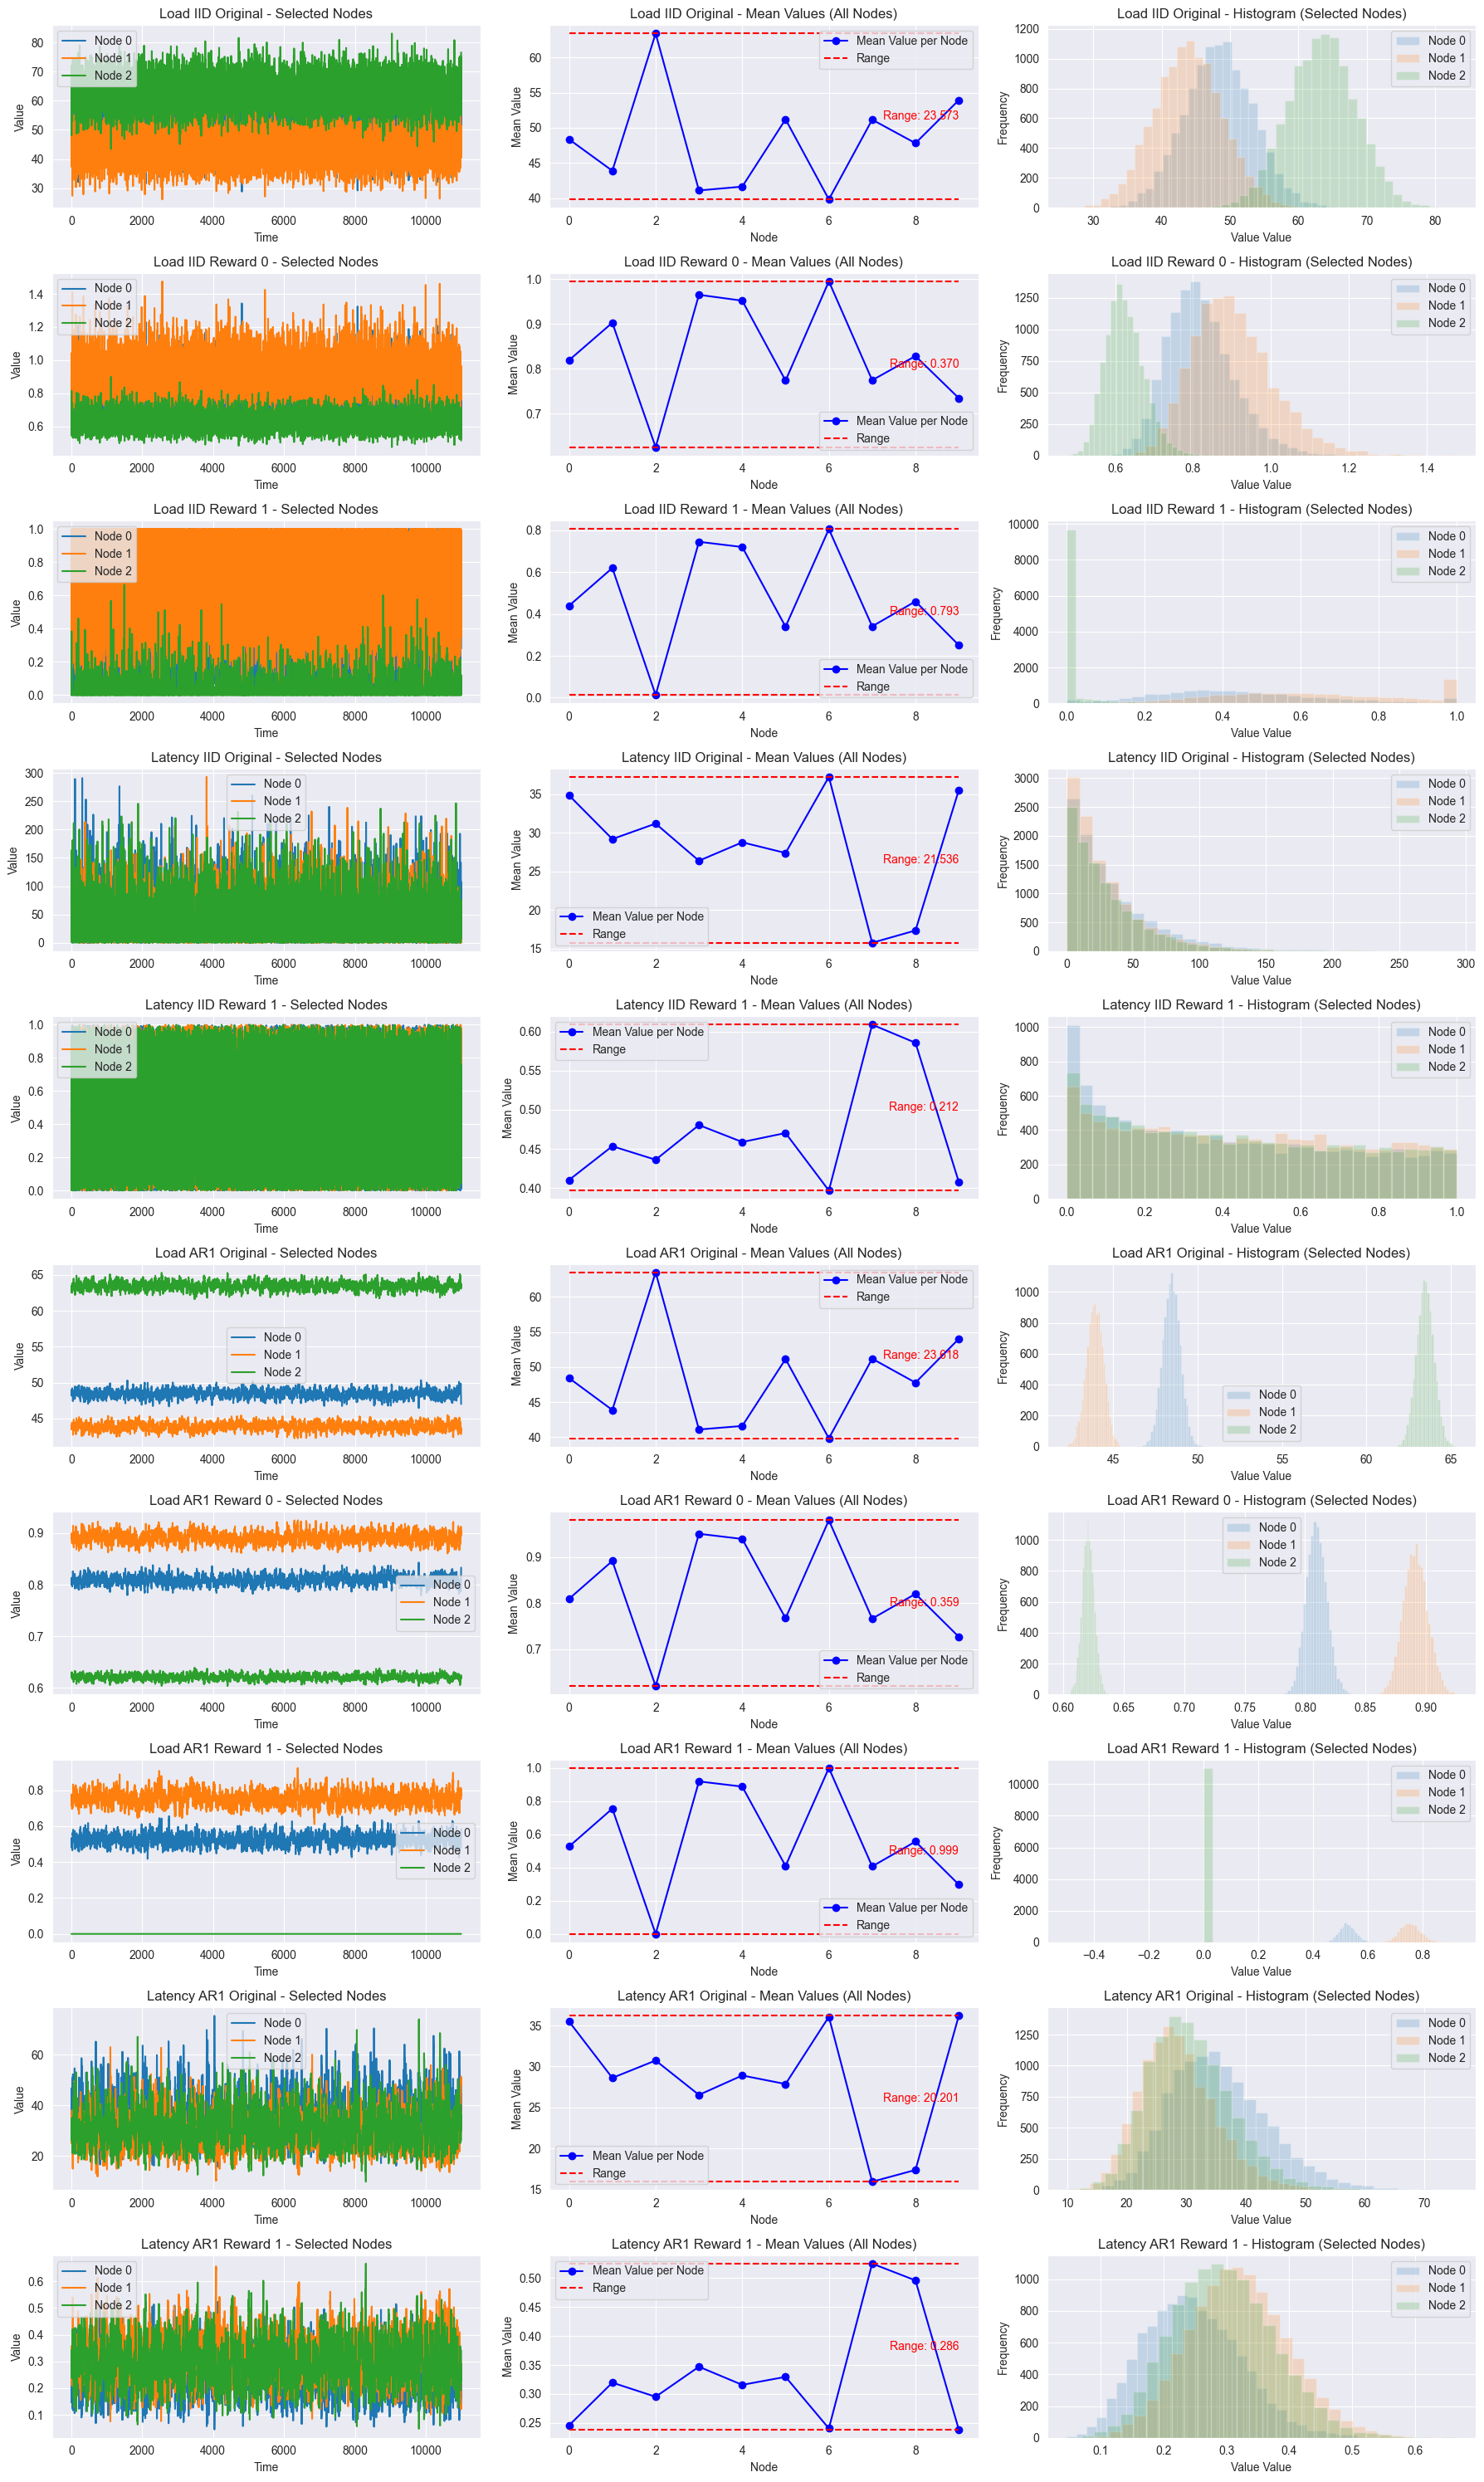

In [39]:
reward_data_calculator.plot_reward_data()

In [91]:
class DataManager:
    def __init__(self, config: DictConfig, data_type: str) -> None:
        """
        初始化 TrainValidManage 类，接受一个 omegaconf 的 DictConfig 对象作为配置，并将
        所需的配置项提取为类属性。

        :param config: 配置文件，使用 omegaconf 加载的 DictConfig 对象
        """
        # 提取并保存配置项
        base_config = config.base
        exp4_config = config.exp4

        # self.data_type = base_config.data_type  # 从 base_config 提取 data_type
        self.data_type = data_type
        self.device = exp4_config.device  # 从 exp4_config 提取设备信息
        self.batch_size = exp4_config.batch_size
        self.num_workers = exp4_config.num_workers
        self.N = base_config.N
        self.T = base_config.T
        self.T_train = base_config.T_train
        self.T_val = base_config.T_val
        self.train_ratio = base_config.train_ratio
        self.T_train_val = base_config.T_train_val
        self.T_test = base_config.T_test
        self.seq_length = exp4_config.seq_length

        # 加载数据
        self.load_iid = pd.read_csv(data_path/'load_iid_data.csv').values
        self.load_ar1 = pd.read_csv(data_path/'load_ar1_data.csv').values
        self.latency_iid = pd.read_csv(data_path/'latency_iid_data.csv').values
        self.latency_ar1 = pd.read_csv(data_path/'latency_ar1_data.csv').values

        # 根据数据类型选择数据
        match self.data_type:
            case 'load_iid':
                self.data_np = self.load_iid
            case 'load_ar1':
                self.data_np = self.load_ar1
            case 'latency_iid':
                self.data_np = self.latency_iid
            case 'latency_ar1':
                self.data_np = self.latency_ar1
            case _:
                raise ValueError(f"Unknown data_type: {self.data_type}")

        # 将数据转换为 PyTorch 张量
        self.data_tensor = torch.tensor(self.data_np, device=self.device, dtype=torch.float32)

        # 划分np.array的训练集、验证集和测试集
        self.train_val_data_np = self.data_np[:, :self.T_train_val]
        self.train_data_np = self.data_np[:, :self.T_train]
        self.val_data_np = self.data_np[:, self.T_train:self.T_train_val]
        self.test_data_np = self.data_np[:, self.T_train_val:]

        # 储存tensor的训练集、验证集和测试集
        self.train_val_data_tensor = torch.tensor(self.train_val_data_np, device=self.device, dtype=torch.float32)
        self.train_data_tensor = torch.tensor(self.train_data_np, device=self.device, dtype=torch.float32)
        self.val_data_tensor = torch.tensor(self.val_data_np, device=self.device, dtype=torch.float32)
        self.test_data_tensor = torch.tensor(self.test_data_np, device=self.device, dtype=torch.float32)

        # 创建训练集、验证集、训练验证集的序列数据
        self.train_val_x, self.train_val_y = self._create_sequences(self.data_np, 'train_val')
        self.train_x, self.train_y = self._create_sequences(self.data_np, 'train')
        self.val_x, self.val_y = self._create_sequences(self.data_np, 'val')

        # 创建TensorDataset，用于创建DataLoader
        self.train_val_dataset = TensorDataset(self.train_val_x, self.train_val_y)
        self.train_dataset = TensorDataset(self.train_x, self.train_y)
        self.val_dataset = TensorDataset(self.val_x, self.val_y)

        # 创建数据加载器
        self.train_val_dataloader = DataLoader(self.train_val_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        self.train_dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        self.val_dataloader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

        # 创建GNN的边索引
        self.edge_index_tensor = torch.tensor(
            np.array([(i, j) for i in range(self.N) for j in range(self.N)]).T,
            dtype=torch.long)  # 默认全连接图

        # 打印信息
        self.print_train_valid_info()

    def _create_sequences(self, data: np.ndarray, split_type: str) -> tuple[torch.Tensor, torch.Tensor]:
        """
        根据数据创建序列数据。

        :param data: 输入的numpy数组数据
        :param split_type: 数据的切分类型（'train', 'val', 'train_val'）
        :return: 生成的输入序列张量和目标序列张量
        """
        x, y = [], []

        if split_type == 'train':
            # 训练集，从1到8000 (用1-20预测21)
            for i in range(self.seq_length, self.T_train):
                x.append(data[:, i - self.seq_length:i].T)
                y.append(data[:, i])

        elif split_type == 'val':
            # 验证集，从8001到10000 (用7981-8000预测8001)
            for i in range(self.T_train, self.T_train_val):
                x.append(data[:, i - self.seq_length:i].T)
                y.append(data[:, i])

        elif split_type == 'train_val':
            # 训练验证集，从1到10000 (用1-20预测21)
            for i in range(self.seq_length, self.T_train_val):
                x.append(data[:, i - self.seq_length:i].T)
                y.append(data[:, i])

        return torch.tensor(np.array(x)), torch.tensor(np.array(y))

    def print_train_valid_info(self) -> None:
        """
        打印训练和验证数据的信息。
        """
        print(f'================= Data Info =================')
        print(f'----------------- Base Info-----------------')
        print(f'data_type: {self.data_type}')
        print(f'device: {self.device}')
        print(f'batch_size: {self.batch_size}')
        print(f'num_workers: {self.num_workers}')
        print(f'N: {self.N}')
        print(f'T: {self.T}')
        print(f'T_train: {self.T_train}')
        print(f'T_val: {self.T_val}')
        print(f'train_ratio: {self.train_ratio}')
        print(f'T_train_val: {self.T_train_val}')
        print(f'T_test: {self.T_test}')
        print(f'seq_length: {self.seq_length}')

        print(f'----------------- Data Info -----------------')
        print(f'load_iid.shape: {self.load_iid.shape}')
        print(f'load_ar1.shape: {self.load_ar1.shape}')
        print(f'latency_iid.shape: {self.latency_iid.shape}')
        print(f'latency_ar1.shape: {self.latency_ar1.shape}')
        print(f'data_np.shape: {self.data_np.shape}')
        print(f'data_tensor.shape: {self.data_tensor.shape}')

        print(f'----------------- Split Info -----------------')
        print('train_val_data_np.shape:', self.train_val_data_np.shape)
        print('train_data_np.shape:', self.train_data_np.shape)
        print('val_data_np.shape:', self.val_data_np.shape)
        print('test_data_np.shape:', self.test_data_np.shape)
        print('train_val_data_tensor.shape:', self.train_val_data_tensor.shape)
        print('train_data_tensor.shape:', self.train_data_tensor.shape)
        print('val_data_tensor.shape:', self.val_data_tensor.shape)
        print('test_data_tensor.shape:', self.test_data_tensor.shape)

        print(f'----------------- Sequence Info -----------------')
        print('train_val_x.shape:', self.train_val_x.shape)
        print('train_val_y.shape:', self.train_val_y.shape)
        print('train_x.shape:', self.train_x.shape)
        print('train_y.shape:', self.train_y.shape)
        print('val_x.shape:', self.val_x.shape)
        print('val_y.shape:', self.val_y.shape)

        print(f'----------------- DataLoader Info -----------------')
        self.print_dataloader_info(self.train_val_dataloader, 'Train-Val')
        self.print_dataloader_info(self.train_dataloader, 'Train')
        self.print_dataloader_info(self.val_dataloader, 'Val')

        print(f'----------------- Edge Index Info -----------------')
        print('edge_index_tensor.shape:', self.edge_index_tensor.shape)

        print(f'===================== End Info =====================')

    def print_dataloader_info(self, dataloader: DataLoader, title: str) -> None:
        """
        打印 DataLoader 的信息。

        :param dataloader: DataLoader 对象
        :param title: 信息标题
        """
        print(f'{"-"*10} {title} Dataloader Info {"-"*10}')

        # 打印头部行，展示 min/max 和 shape 信息
        print(f'{"Batch":<10} {"x.min":<8} {"x.max":<8} {"y.min":<8} {"y.max":<8} {"x.shape:torch.Size":<18} {"y.shape:torch.Size":<18}')

        # 打印每个批次的信息
        for i, (x, y) in enumerate(dataloader):
            if i % 30 == 0 or i == len(dataloader) - 1:
                x_shape_str = str(list(x.shape))  # 使用 list 来缩短 shape 显示
                y_shape_str = str(list(y.shape))

                print(f'{i + 1:>5}/{len(dataloader):<5} '
                      f'{x.min():<8.4f} {x.max():<8.4f} '
                      f'{y.min():<8.4f} {y.max():<8.4f} '
                      f'{x_shape_str:<18} {y_shape_str:<18}')

    def plot_range_data(self, data: np.ndarray, start: int = None, end: int = None, title: str = 'Load Data') -> None:
        """
        绘制指定范围内的数据。

        :param data: 输入数据
        :param start: 开始时间步，默认为0
        :param end: 结束时间步，默认为数据结束
        :param title: 图像标题
        """
        start = 0 if start is None else start
        end = data.shape[1] if end is None else end

        time_steps = np.arange(start, end)
        plt.figure(figsize=(12, 6))
        for i in range(data.shape[0]):
            plt.plot(time_steps, data[i, start:end], label=f'Node {i}')
        plt.title(f'{title} - Nodes {0}-{data.shape[0]}')
        plt.xlabel('Time')
        plt.ylabel('Load')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [92]:
def manage_and_save_data(config: DictConfig, data_type: str, plot_start_node: int, plot_end_node: int, data_path: Path) -> None:
    """
    生成数据，绘图，并保存数据管理对象。

    :param config: 配置对象
    :param data_type: 数据类型，例如 'load_iid', 'load_ar1', 'latency_iid', 'latency_ar1'
    :param data_path: 数据保存的路径
    :param plot_title: 绘图的标题
    """
    # 数据生成
    data_manager = DataManager(config, data_type)

    # 绘图
    data_manager.plot_range_data(data_manager.data_np[plot_start_node:plot_end_node, :], title=f'{data_type} Data')

    # 保存数据
    with open(data_path/f'{data_type}_data_manage.pkl', 'wb') as f:
        pickle.dump(data_manager, f)

---------- Config Info ----------
path:
  global_path: E:/Study in the UK/Project/MScProject
base:
  'N': 10
  T: 11000
  T_train_val: 10000
  train_ratio: 0.8
  T_train: 8000
  T_val: 2000
  T_test: 1000
  lambda: 0.5
data_generation:
  load_data:
    node_load_mean_mean: 50.0
    node_load_mean_var: 10.0
    node_load_iid_var: 5.0
    node_load_ar1_theta: 0.9
  latency_data:
    node_latency_mean_mean: 30.0
    node_latency_mean_var: 10.0
    node_latency_ar1_theta: 0.9
  reward_parameters:
    alpha_load_0: 1.0
    alpha_latency_0: 1.0
    alpha_latency_1: 0.5
  reward_parameters_slider:
    alpha_load_0:
      value: 1.0
      min: 0.001
      max: 40.0
      step: 0.01
      description: alpha_load_0
    alpha_latency_0:
      value: 1.0
      min: 0.001
      max: 6.0
      step: 0.01
      description: alpha_latency_0
    alpha_latency_1:
      value: 0.5
      min: 0.0001
      max: 0.5
      step: 0.001
      description: alpha_latency_1
exp4:
  batch_size: 64
  seq_length: 20

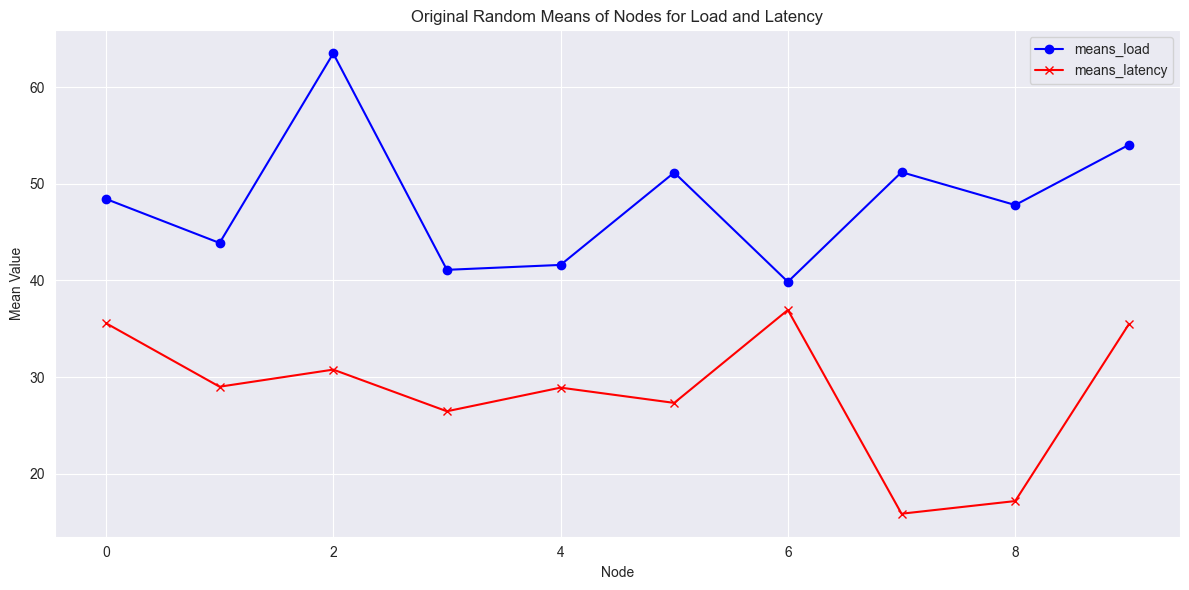

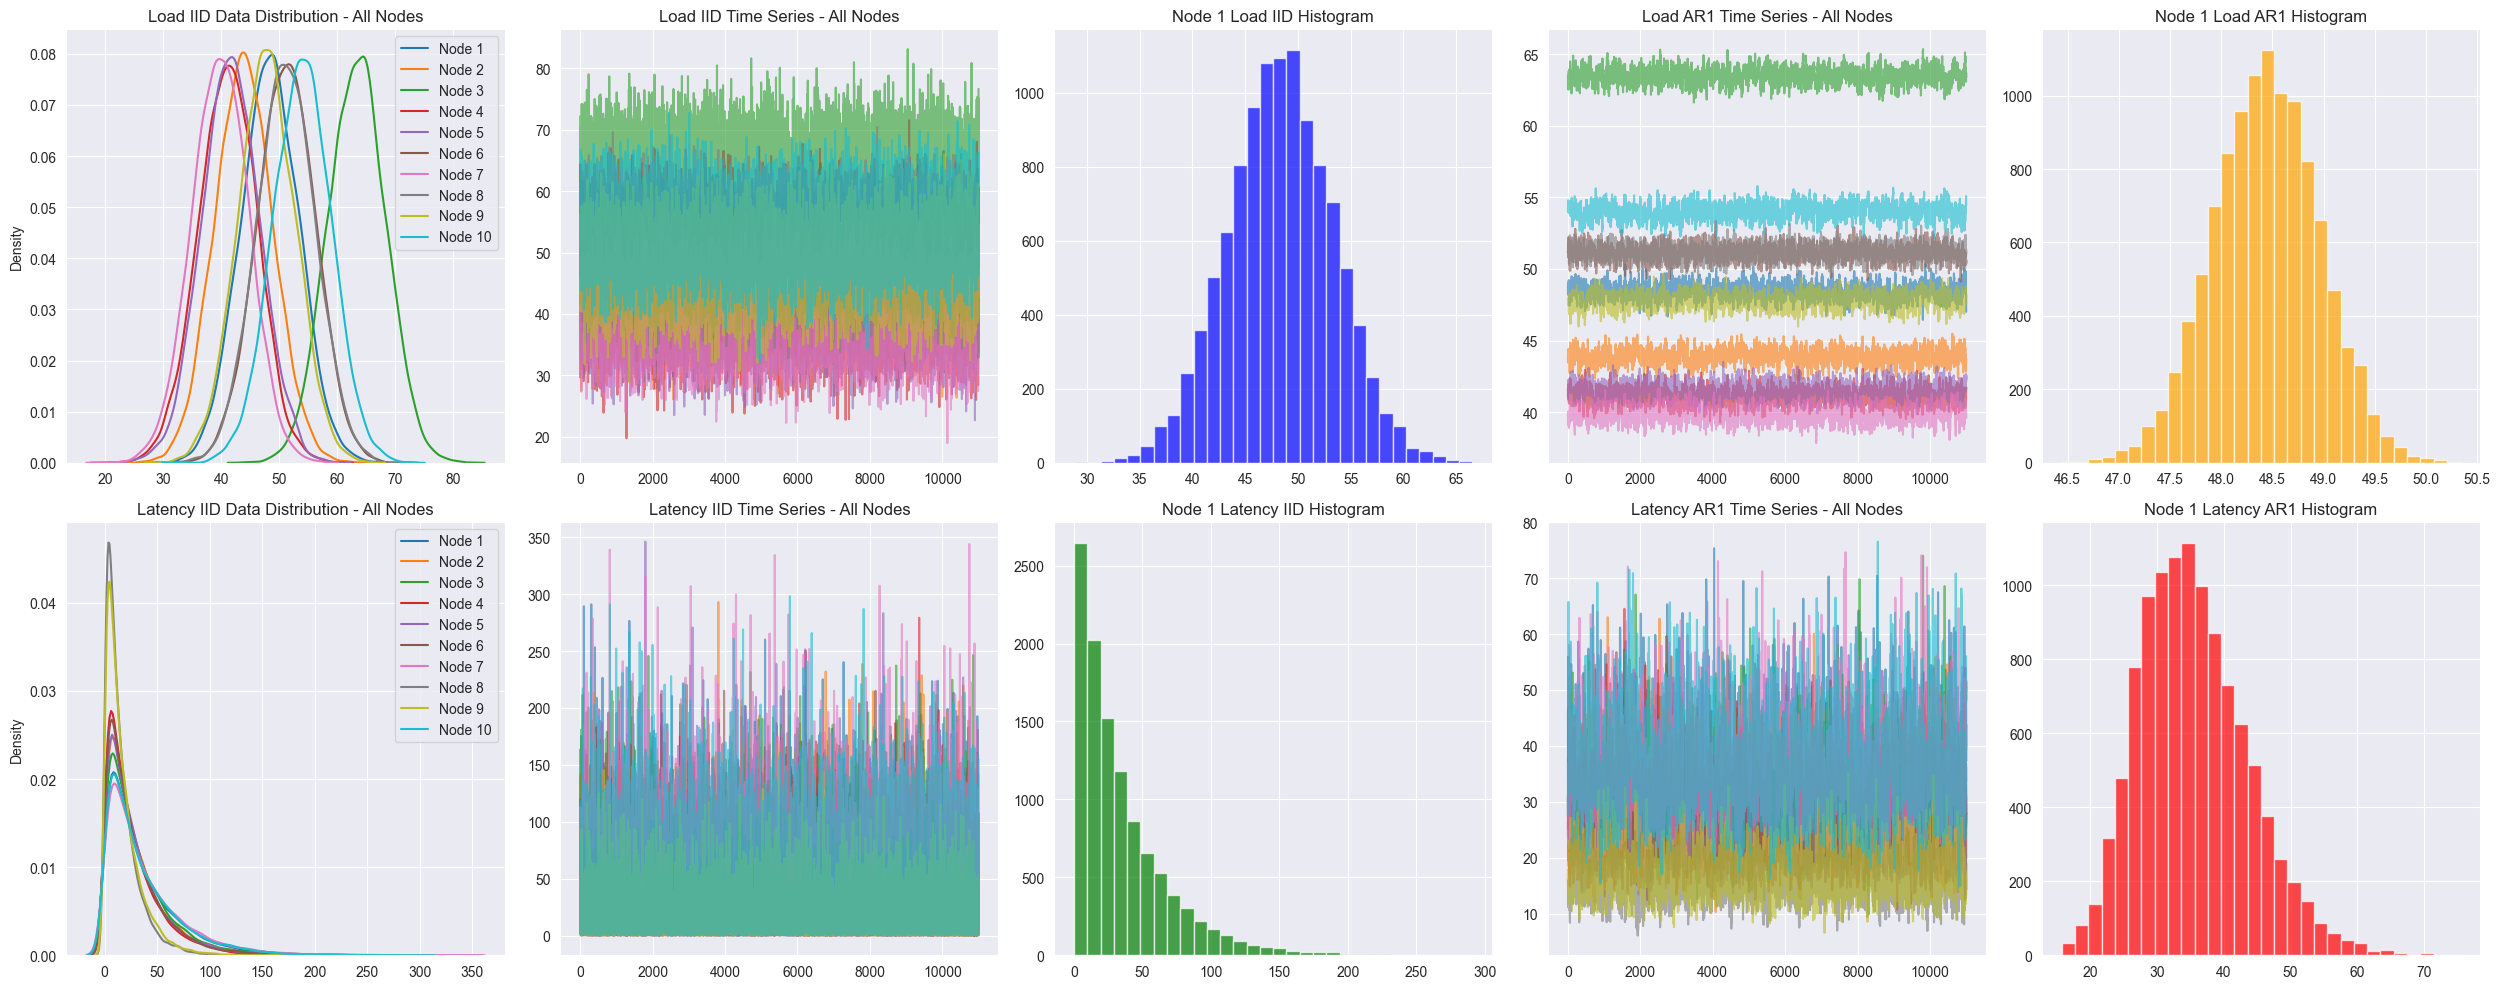

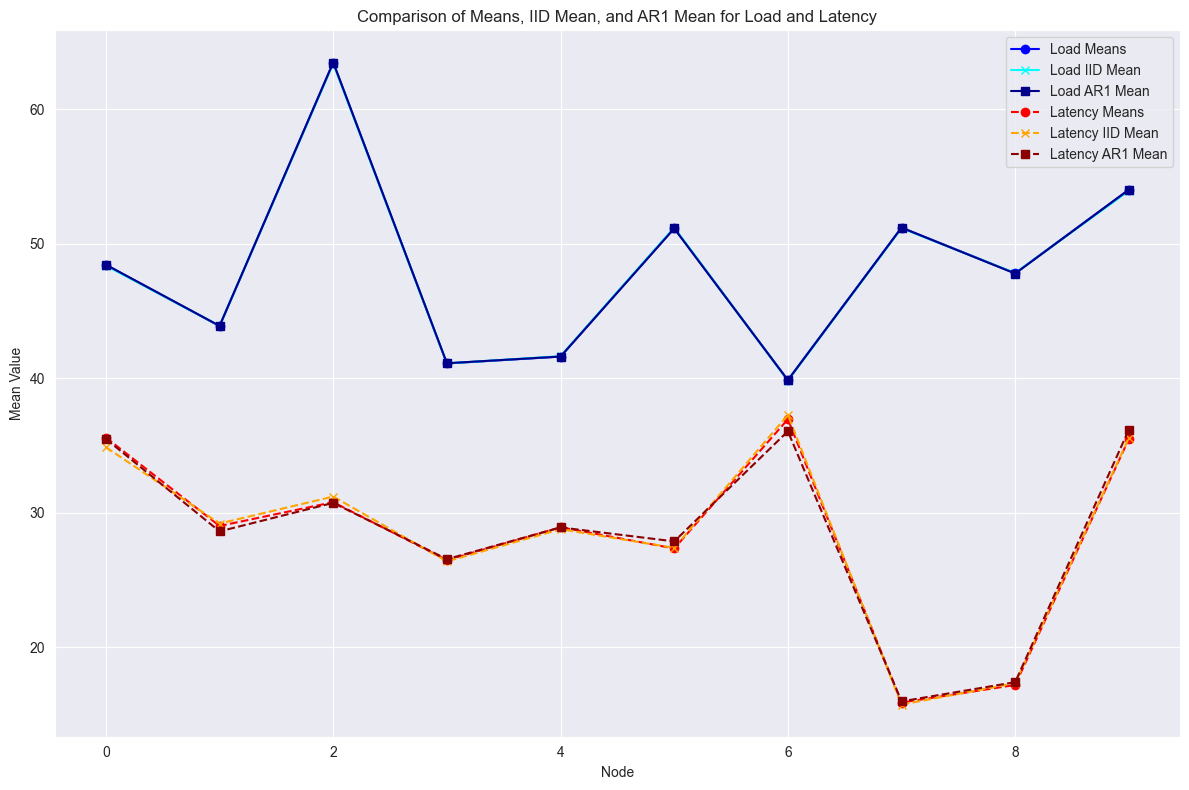

================= Data Info =================
----------------- Base Info-----------------
data_type: load_iid
device: cuda
batch_size: 64
num_workers: 16
N: 10
T: 11000
T_train: 8000
T_val: 2000
train_ratio: 0.8
T_train_val: 10000
T_test: 1000
seq_length: 20
----------------- Data Info -----------------
load_iid.shape: (10, 11000)
load_ar1.shape: (10, 11000)
latency_iid.shape: (10, 11000)
latency_ar1.shape: (10, 11000)
data_np.shape: (10, 11000)
data_tensor.shape: torch.Size([10, 11000])
----------------- Split Info -----------------
train_val_data_np.shape: (10, 10000)
train_data_np.shape: (10, 8000)
val_data_np.shape: (10, 2000)
test_data_np.shape: (10, 1000)
train_val_data_tensor.shape: torch.Size([10, 10000])
train_data_tensor.shape: torch.Size([10, 8000])
val_data_tensor.shape: torch.Size([10, 2000])
test_data_tensor.shape: torch.Size([10, 1000])
----------------- Sequence Info -----------------
train_val_x.shape: torch.Size([9980, 20, 10])
train_val_y.shape: torch.Size([9980, 10

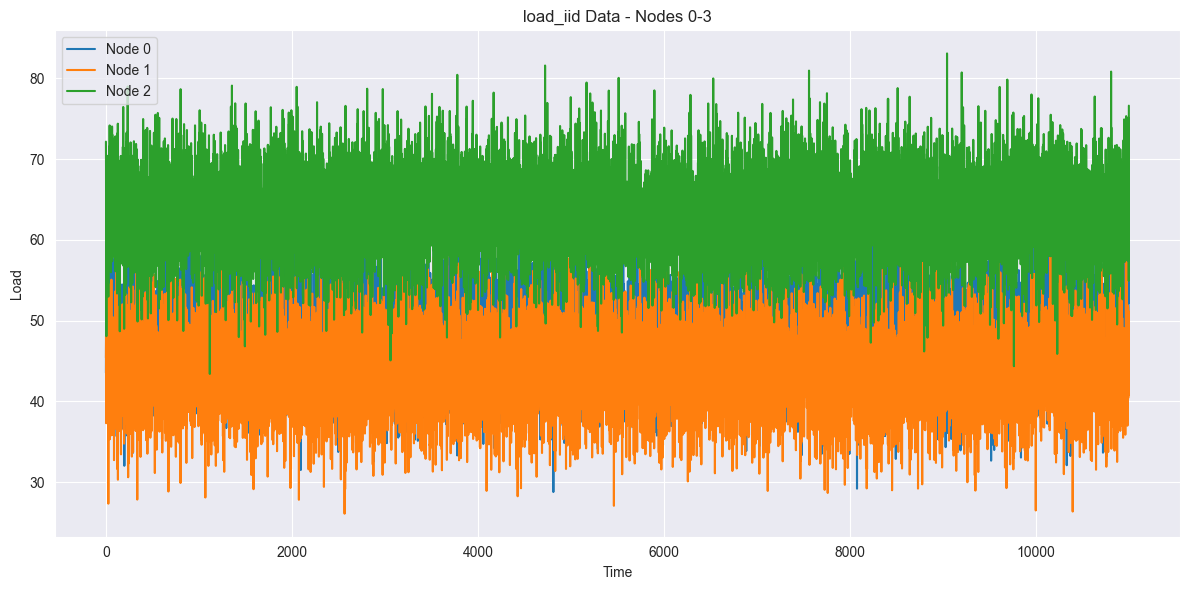

================= Data Info =================
----------------- Base Info-----------------
data_type: load_ar1
device: cuda
batch_size: 64
num_workers: 16
N: 10
T: 11000
T_train: 8000
T_val: 2000
train_ratio: 0.8
T_train_val: 10000
T_test: 1000
seq_length: 20
----------------- Data Info -----------------
load_iid.shape: (10, 11000)
load_ar1.shape: (10, 11000)
latency_iid.shape: (10, 11000)
latency_ar1.shape: (10, 11000)
data_np.shape: (10, 11000)
data_tensor.shape: torch.Size([10, 11000])
----------------- Split Info -----------------
train_val_data_np.shape: (10, 10000)
train_data_np.shape: (10, 8000)
val_data_np.shape: (10, 2000)
test_data_np.shape: (10, 1000)
train_val_data_tensor.shape: torch.Size([10, 10000])
train_data_tensor.shape: torch.Size([10, 8000])
val_data_tensor.shape: torch.Size([10, 2000])
test_data_tensor.shape: torch.Size([10, 1000])
----------------- Sequence Info -----------------
train_val_x.shape: torch.Size([9980, 20, 10])
train_val_y.shape: torch.Size([9980, 10

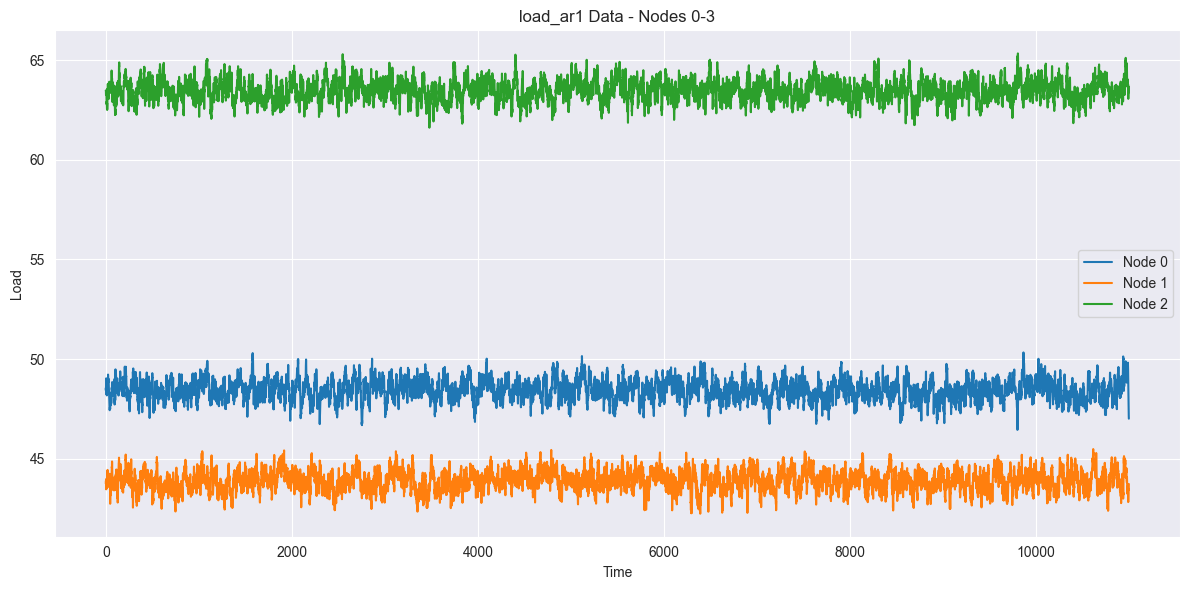

================= Data Info =================
----------------- Base Info-----------------
data_type: latency_iid
device: cuda
batch_size: 64
num_workers: 16
N: 10
T: 11000
T_train: 8000
T_val: 2000
train_ratio: 0.8
T_train_val: 10000
T_test: 1000
seq_length: 20
----------------- Data Info -----------------
load_iid.shape: (10, 11000)
load_ar1.shape: (10, 11000)
latency_iid.shape: (10, 11000)
latency_ar1.shape: (10, 11000)
data_np.shape: (10, 11000)
data_tensor.shape: torch.Size([10, 11000])
----------------- Split Info -----------------
train_val_data_np.shape: (10, 10000)
train_data_np.shape: (10, 8000)
val_data_np.shape: (10, 2000)
test_data_np.shape: (10, 1000)
train_val_data_tensor.shape: torch.Size([10, 10000])
train_data_tensor.shape: torch.Size([10, 8000])
val_data_tensor.shape: torch.Size([10, 2000])
test_data_tensor.shape: torch.Size([10, 1000])
----------------- Sequence Info -----------------
train_val_x.shape: torch.Size([9980, 20, 10])
train_val_y.shape: torch.Size([9980,

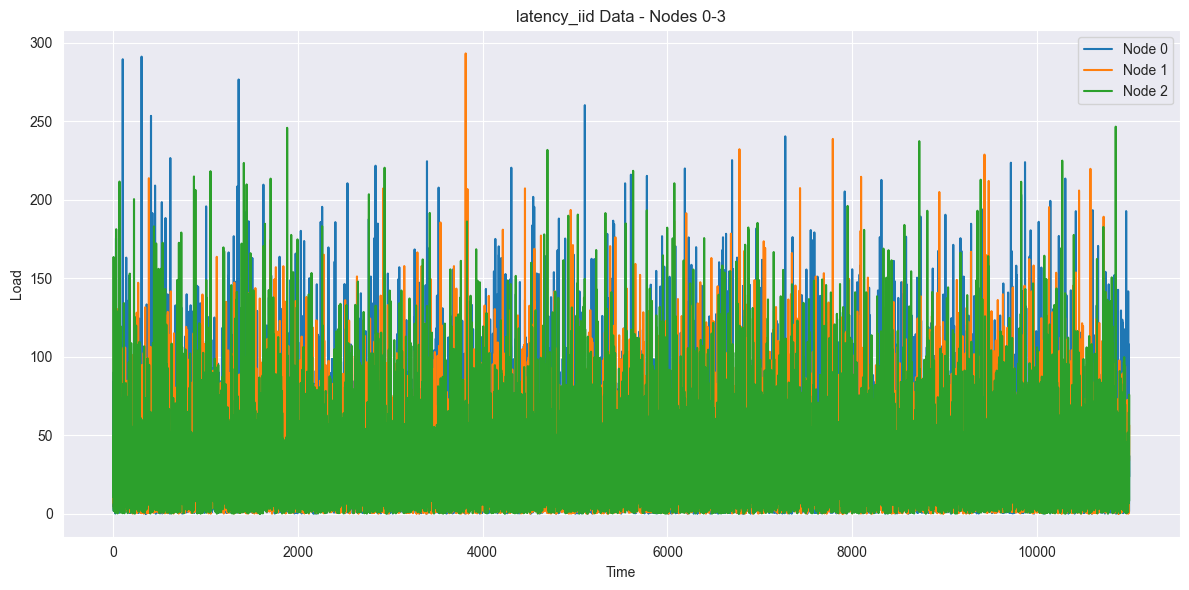

================= Data Info =================
----------------- Base Info-----------------
data_type: latency_ar1
device: cuda
batch_size: 64
num_workers: 16
N: 10
T: 11000
T_train: 8000
T_val: 2000
train_ratio: 0.8
T_train_val: 10000
T_test: 1000
seq_length: 20
----------------- Data Info -----------------
load_iid.shape: (10, 11000)
load_ar1.shape: (10, 11000)
latency_iid.shape: (10, 11000)
latency_ar1.shape: (10, 11000)
data_np.shape: (10, 11000)
data_tensor.shape: torch.Size([10, 11000])
----------------- Split Info -----------------
train_val_data_np.shape: (10, 10000)
train_data_np.shape: (10, 8000)
val_data_np.shape: (10, 2000)
test_data_np.shape: (10, 1000)
train_val_data_tensor.shape: torch.Size([10, 10000])
train_data_tensor.shape: torch.Size([10, 8000])
val_data_tensor.shape: torch.Size([10, 2000])
test_data_tensor.shape: torch.Size([10, 1000])
----------------- Sequence Info -----------------
train_val_x.shape: torch.Size([9980, 20, 10])
train_val_y.shape: torch.Size([9980,

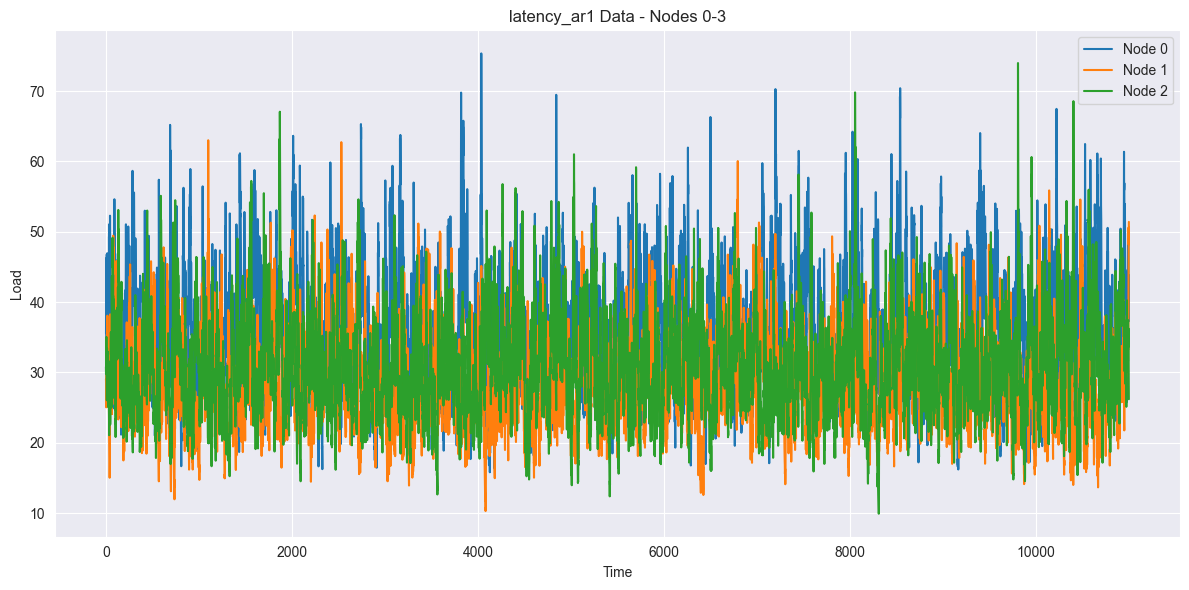

In [93]:
if __name__ == '__main__':

    # 加载 config.yaml 文件
    config = OmegaConf.load("config/config.yaml")
    global_path = Path(config.path.global_path)
    data_path = global_path / 'Data'
    # 打印完整的配置内容
    print(f'---------- Config Info ----------')
    print(OmegaConf.to_yaml(config))
    # 打印全局路径和数据路径
    print(f'---------- Path Info ----------')
    print(f'Global Path: {global_path}')
    print(f'Data Path: {data_path}')

    # 数据生成
    data_generate = DataGenerator(config, if_save=True)

    # 数据管理
    manage_and_save_data(config, 'load_iid', 0, 3, data_path)
    manage_and_save_data(config, 'load_ar1', 0, 3, data_path)
    manage_and_save_data(config, 'latency_iid', 0, 3, data_path)
    manage_and_save_data(config, 'latency_ar1', 0, 3, data_path)